In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
Measurement_first_row = session.query(Measurement).first()
Measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e9d32d1648>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
Station_first_row = session.query(Station).first()
Station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e9d32fb3c8>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point in the database
date = dt.datetime(2017,8,23)
one_year_ago = date- dt.timedelta(days=366)
one_year_ago

datetime.datetime(2016, 8, 22, 0, 0)

In [16]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-22').order_by(Measurement.date).all()


In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd. DataFrame(precipitation, columns = ['date', 'prcp'])
precipitation_df.head()

,date,prcp
0,2016-08-22,0.40
1,2016-08-22,0.94
2,2016-08-22,NaN
3,2016-08-22,NaN
4,2016-08-22,0.40


In [18]:
precipitation_df.set_index('date', inplace =True)
precipitation_df.head()

,prcp
date,
2016-08-22,0.40
2016-08-22,0.94
2016-08-22,NaN
2016-08-22,NaN
2016-08-22,0.40


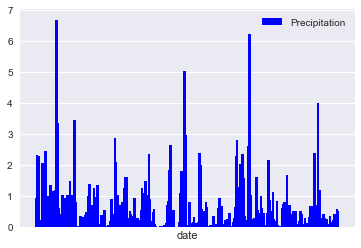

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
y = precipitation_df["prcp"]
x = np.arange(len(precipitation_df.index))
plt.bar(x, y, width=20, color="b")
# Set label
plt.xlabel("date")
plt.xticks([])
plt.legend(["Precipitation"])
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df['prcp'].describe()

count    2026.000000
mean        0.179437
std         0.463989
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
           group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
           filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations. Result: Station is 'USC00519281'
session.query(Measurement.station,func.count(Measurement.tobs)).\
           group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# the last date for Station USC00519281
session.query(Measurement.date).order_by(Measurement.date.desc()).filter(Measurement.station == 'USC00519281').first()

('2017-08-18')

In [34]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.tobs).\
        filter(Measurement.date >= '2016-08-17').\
        filter(Measurement.station == 'USC00519281').\
        order_by(Measurement.tobs.desc()).all()


In [28]:
temperature_df = pd. DataFrame(temperature, columns = ['tobs'])
temperature_df.head()

,tobs
0,83.0
1,82.0
2,82.0
3,82.0
4,82.0


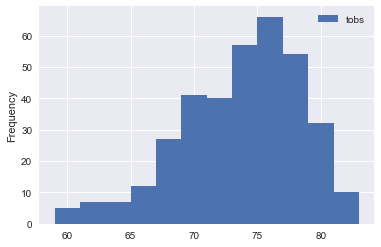

In [29]:
temperature_df.plot.hist(bins=12)

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = "2017-12-05 to 2017-12-13"
prev_year = "2016-12-05 - \n 2016-12-13"

prev_year_start = dt.date(2017, 12, 5) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 12, 13) - dt.timedelta(days=365)

temps = calc_temps(prev_year_start, prev_year_end)
temp_min, temp_avg, temp_max = temps[0]

print("Here are your Trip's Weather Results!")
print(f" Min Temp : {temp_min}F")
print(f" Avg Temp : {temp_avg}F")
print(f" Max Temp : {temp_max}F")

Here are your Trip's Weather Results!
 Min Temp : 65.0F
 Avg Temp : 69.98275862068965F
 Max Temp : 78.0F


(0, 105)

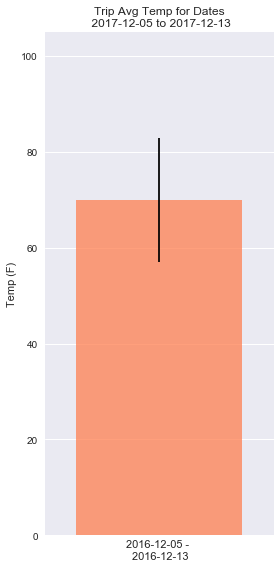

In [33]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = temp_max - temp_min
xpos = 1

plt.figure(figsize=(4, 8))
plt.bar(xpos, temp_avg, yerr=error, alpha=0.75, color="coral")
plt.title(f"Trip Avg Temp for Dates\n {trip_dates}")
plt.xlabel(f"{prev_year}")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)

In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start = "2016-08-17"
trip_end = "2016-12-13"

rain_station = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.avg(Measurement.prcp),
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(trip_start, trip_end),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)

# Convert query object to data frame
rain_df = pd.DataFrame(np.array(rain_station))
rain_df = rain_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation",
    }
)

rain_df

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.646228070175439
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.21277310924369752
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.11337209302325575
3,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.10714285714285705
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.09265486725663714
5,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.06333333333333334
6,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.047606837606837586


## Optional Challenge Assignment

In [48]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_startdate = dt.date(2017, 8, 17)
trip_enddate = dt.date(2017, 12, 13)

# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_startdate, trip_enddate)

# Stip off the year and save a list of %m-%d strings
date_list = [d.strftime("%m-%d") for d in date_range]
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal = [daily_normals(d)[0] for d in date_list]


In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df

,tmin,tavg,tmax
Date,,,
2017-08-17,69.0,76.125000,83.0
2017-08-18,70.0,76.923077,84.0
2017-08-19,69.0,75.946429,85.0
2017-08-20,68.0,76.452830,82.0
2017-08-21,67.0,76.400000,83.0
...,...,...,...
2017-12-09,64.0,71.901961,80.0
2017-12-10,61.0,71.245283,78.0
2017-12-11,64.0,72.387755,78.0


Text(0, 0.5, 'Temperature(F)')

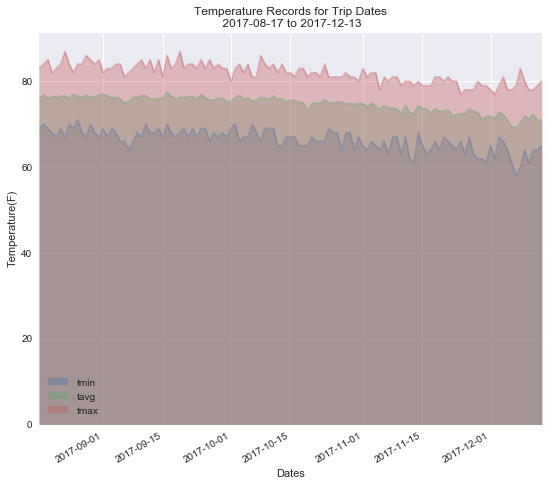

In [52]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.title(f"Temperature Records for Trip Dates\n {trip_startdate} to {trip_enddate}")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")